In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
BSZ = 16
EPOCH = 20
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

In [3]:
def sigmoid(x, deriv=False):
  """
  returns the derivative or 
  """
  if deriv:
      return sigmoid(x) * (1-sigmoid(x))
  return (1.0 / (1.0 + torch.exp(-x)))


def softmax(x):
  """
  implementation for the sigmoid function for the forward pass
  pay attention to sum dimension and .view(-1,1)
  """
  exps = torch.exp(x)
  sums = torch.sum(exps, dim=1).view(-1,1) 
  return torch.div(exps, sums)

def delta_cross_entropy(X,y):
  """
  Derivative is taken from here https://deepnotes.io/softmax-crossentropy#derivative-of-cross-entropy-loss-with-softmax
  and adapted for softmax already applied to the input

  calculates the gradient of the cross entropy loss with softmax
  X is the output from the ouput layer, softmax is already applied
  y are the labels, one hot encoded
  """
  m = y.size()[0]
  grad = X
  grad = grad - y
  grad = grad/m
  return grad


def crossEntropy(predictions, targets):
  """
  prediction is a list of torch tensors, and target is a list of one hot encoded targets
  """
  loss = [- torch.sum(t * torch.log(p)) for p,t in zip(predictions,targets)]
  return sum(loss) / len(loss)


class simpleMLP:
  def __init__(self, input_dim, hidden_dim, output_dim, lr):
      self.input_dim = input_dim
      self.hidden_dim = hidden_dim
      self.output_dim = output_dim
      self.lr = lr
      #init weights, which are uniformly distributed in [-0.5, 0.5]
      self.W1 = torch.rand(self.input_dim, self.hidden_dim, dtype=torch.float32) - 0.5
      self.W2 = torch.rand(self.hidden_dim, self.output_dim, dtype=torch.float32) - 0.5

  def forward(self, mini_batch):
    hidden_output = sigmoid(torch.matmul(mini_batch, self.W1))
    #we used the derivative for cross entropy with softmax from this website
    #https://deepnotes.io/softmax-crossentropy#derivative-of-cross-entropy-loss-with-softmax 
    output = softmax(torch.matmul(hidden_output, self.W2))
    return hidden_output, output

  def backward(self, input_batch, hidden_output, output, labels):

    #calculate the loss (only for plotting)
    loss = crossEntropy(output, torch.nn.functional.one_hot(labels, num_classes=10))
    #calculate the delta for the second layer
    second_delta = delta_cross_entropy(output, torch.nn.functional.one_hot(labels, num_classes=10))


    #calculate the deltas for the first layer
    hidden_delta = torch.matmul(second_delta, self.W2.T)
    first_delta = hidden_delta * sigmoid(hidden_output, deriv=True)


    #SGD execution
    self.W2 -= self.lr * torch.matmul(hidden_output.T, second_delta)
    self.W1 -= self.lr * torch.matmul(input_batch.T, first_delta)
    return loss




In [4]:
data_transform = transforms.Compose([transforms.Resize(32), transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=data_transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=data_transform, download=True)

In [5]:
train_loader = DataLoader(train_dataset, batch_size=BSZ, shuffle=True, drop_last=False)
test_loader = DataLoader(train_dataset, batch_size=BSZ, shuffle=True, drop_last=False)

In [6]:
model = simpleMLP(1024, 128, 10, 1e-3)

In [7]:
losses = []
accuracies = []

for e in range(EPOCH):
    loss_sum = 0
    for idx, (X, label) in enumerate(tqdm(train_loader)):
        hidden, output = model.forward(X.flatten(1,3))
        loss = model.backward(X.flatten(1,3), hidden, output, label)
        loss_sum += loss.item()
    print('Epochs: {}/{}'.format(e + 1, EPOCH), 'batch_loss:{:.4f}'.format(loss_sum/len(train_loader)))
    correct = 0
    #I have a minor error in the accuracy calculation here, if someone of ypu has time, maybe try to fix :)
    for idx, (X, label) in enumerate(tqdm(test_loader)):
        
        _, predictions = model.forward(X.flatten(1,3))
        _, predicted_labels = torch.max(predictions, axis=1)
        correct += torch.sum(predicted_labels == label).item()
    
    print('Epochs: {}/{}'.format(e + 1, EPOCH), 'Accuracy:{:.4f}'.format(correct/len(test_loader) / BSZ))
    accuracies.append(correct/len(test_loader) / BSZ)
    losses.append(loss_sum/len(train_loader))


100%|██████████| 3750/3750 [00:11<00:00, 313.95it/s]


Epochs: 1/20 batch_loss:1.9265


100%|██████████| 3750/3750 [00:08<00:00, 428.61it/s]


Epochs: 1/20 Accuracy:0.5886


100%|██████████| 3750/3750 [00:11<00:00, 324.24it/s]


Epochs: 2/20 batch_loss:1.1412


100%|██████████| 3750/3750 [00:08<00:00, 429.73it/s]


Epochs: 2/20 Accuracy:0.7253


100%|██████████| 3750/3750 [00:11<00:00, 318.84it/s]


Epochs: 3/20 batch_loss:0.8835


100%|██████████| 3750/3750 [00:09<00:00, 414.49it/s]


Epochs: 3/20 Accuracy:0.7836


100%|██████████| 3750/3750 [00:11<00:00, 332.62it/s]


Epochs: 4/20 batch_loss:0.7522


100%|██████████| 3750/3750 [00:08<00:00, 459.94it/s]


Epochs: 4/20 Accuracy:0.8099


100%|██████████| 3750/3750 [00:10<00:00, 343.30it/s]


Epochs: 5/20 batch_loss:0.6719


100%|██████████| 3750/3750 [00:08<00:00, 449.55it/s]


Epochs: 5/20 Accuracy:0.8258


100%|██████████| 3750/3750 [00:11<00:00, 322.32it/s]


Epochs: 6/20 batch_loss:0.6175


100%|██████████| 3750/3750 [00:08<00:00, 455.31it/s]


Epochs: 6/20 Accuracy:0.8372


100%|██████████| 3750/3750 [00:10<00:00, 345.93it/s]


Epochs: 7/20 batch_loss:0.5780


100%|██████████| 3750/3750 [00:08<00:00, 446.10it/s]


Epochs: 7/20 Accuracy:0.8447


100%|██████████| 3750/3750 [00:11<00:00, 333.19it/s]


Epochs: 8/20 batch_loss:0.5478


100%|██████████| 3750/3750 [00:08<00:00, 454.67it/s]


Epochs: 8/20 Accuracy:0.8512


100%|██████████| 3750/3750 [00:11<00:00, 339.98it/s]


Epochs: 9/20 batch_loss:0.5237


100%|██████████| 3750/3750 [00:08<00:00, 458.01it/s]


Epochs: 9/20 Accuracy:0.8569


100%|██████████| 3750/3750 [00:10<00:00, 345.60it/s]


Epochs: 10/20 batch_loss:0.5040


100%|██████████| 3750/3750 [00:08<00:00, 457.15it/s]


Epochs: 10/20 Accuracy:0.8603


100%|██████████| 3750/3750 [00:10<00:00, 342.85it/s]


Epochs: 11/20 batch_loss:0.4875


100%|██████████| 3750/3750 [00:08<00:00, 455.89it/s]


Epochs: 11/20 Accuracy:0.8644


100%|██████████| 3750/3750 [00:10<00:00, 342.15it/s]


Epochs: 12/20 batch_loss:0.4736


100%|██████████| 3750/3750 [00:08<00:00, 452.13it/s]


Epochs: 12/20 Accuracy:0.8682


100%|██████████| 3750/3750 [00:11<00:00, 331.07it/s]


Epochs: 13/20 batch_loss:0.4614


100%|██████████| 3750/3750 [00:08<00:00, 437.88it/s]


Epochs: 13/20 Accuracy:0.8709


100%|██████████| 3750/3750 [00:11<00:00, 337.81it/s]


Epochs: 14/20 batch_loss:0.4509


100%|██████████| 3750/3750 [00:08<00:00, 436.51it/s]


Epochs: 14/20 Accuracy:0.8736


100%|██████████| 3750/3750 [00:11<00:00, 327.38it/s]


Epochs: 15/20 batch_loss:0.4415


100%|██████████| 3750/3750 [00:08<00:00, 430.49it/s]


Epochs: 15/20 Accuracy:0.8762


100%|██████████| 3750/3750 [00:11<00:00, 325.30it/s]


Epochs: 16/20 batch_loss:0.4332


100%|██████████| 3750/3750 [00:08<00:00, 436.70it/s]


Epochs: 16/20 Accuracy:0.8787


100%|██████████| 3750/3750 [00:11<00:00, 327.47it/s]


Epochs: 17/20 batch_loss:0.4256


100%|██████████| 3750/3750 [00:08<00:00, 435.96it/s]


Epochs: 17/20 Accuracy:0.8803


100%|██████████| 3750/3750 [00:11<00:00, 328.67it/s]


Epochs: 18/20 batch_loss:0.4188


100%|██████████| 3750/3750 [00:08<00:00, 430.75it/s]


Epochs: 18/20 Accuracy:0.8819


100%|██████████| 3750/3750 [00:11<00:00, 326.54it/s]


Epochs: 19/20 batch_loss:0.4126


100%|██████████| 3750/3750 [00:08<00:00, 430.24it/s]


Epochs: 19/20 Accuracy:0.8834


100%|██████████| 3750/3750 [00:11<00:00, 324.97it/s]


Epochs: 20/20 batch_loss:0.4069


100%|██████████| 3750/3750 [00:08<00:00, 433.87it/s]

Epochs: 20/20 Accuracy:0.8846


Text(0.5, 1.0, 'Training Accuracy (MLP)')

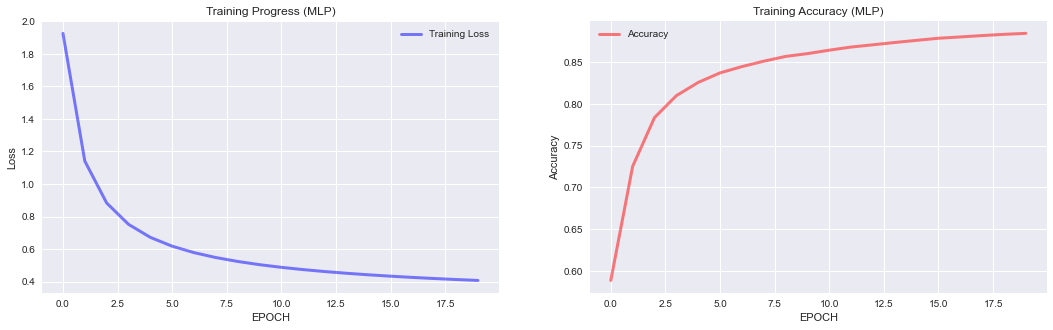

In [8]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,2)
fig.set_size_inches(18,5)

ax[0].plot(losses, c="blue", label="Training Loss", linewidth=3, alpha=0.5)
ax[0].legend(loc="best")
ax[0].set_xlabel("EPOCH")
ax[0].set_ylabel("Loss")
ax[0].set_title("Training Progress (MLP)")


ax[1].plot(accuracies, c="red", label="Accuracy", linewidth=3, alpha=0.5)
ax[1].legend(loc="best")
ax[1].set_xlabel("EPOCH")
ax[1].set_ylabel("Accuracy")
ax[1].set_xscale("linear")
ax[1].set_yscale("linear")
ax[1].set_title("Training Accuracy (MLP)")

### Here is an additional Plot which shows the images, our networks predictions and the real labels:

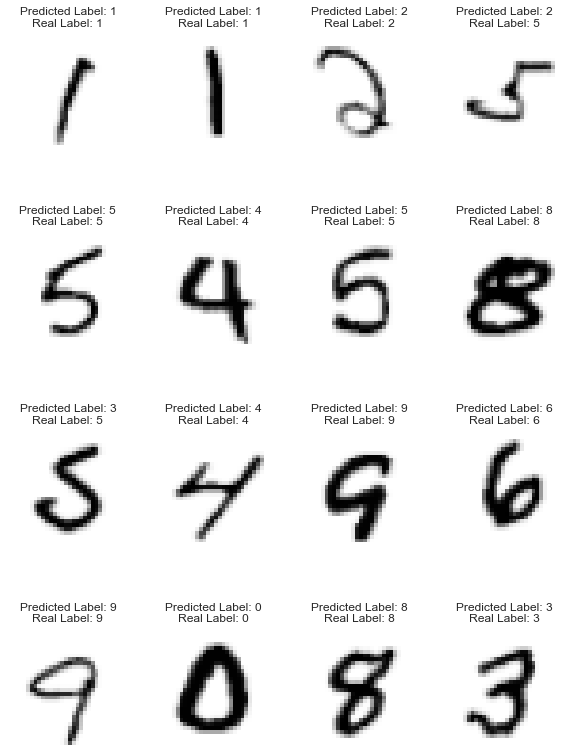

In [9]:
X, label = next(iter(test_loader))
_, predictions = model.forward(X.flatten(1,3))
_, predicted_labels = torch.max(predictions, axis=1)

w = 10
h = 10
fig = plt.figure(figsize=(10, 14))
columns = 4
rows = 4

for i in range(1, columns*rows +1):
    img = X[i-1,0]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Predicted Label: " + str(predicted_labels[i-1].item()) + "\n" + "Real Label: " + str(label[i-1].item()))
plt.show()
